## MOUNT GOOGLE DRIVE

In [1]:
collaboratory = True

if collaboratory:
    from google.colab import drive
    drive.mount('/content/drive')
else: 
    print('Running on local systems, if running on collaboratory please change above')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/Shareddrives/ML-CFD/Code

/content/drive/Shareddrives/ML-CFD/Code


## IMPORT

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from utils.cavity_solver_4d import solve_flow
# from UNet3_outlet_obj import UNet
from UNet_4D_geomask5 import UNet_4D, conv_loss
# from UNet_4D import UNet_4D, conv_loss
from dataset_creator import CavityFlowDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
# from samples import get_samples, get_training_data
from torch.utils import data
import time
# from get_geo_mask import get_geo_mask, get_obj_loc
import os

## Input

In [ ]:
B = torch.load('utils/FlowData_UV_0331_warm_mixed8.pt')
C = F.interpolate(B, size=(32, 32), mode ='bilinear')
# C = F.interpolate(B, size=(32, 32), mode ='nearest')

C[:,0:3,0:1,1:-1] = F.interpolate(B[:,:,0:1,1:-1], size=(1, 30), mode = "nearest")
C[:,0:3,-1:,1:-1] = F.interpolate(B[:,:,-1:,1:-1], size=(1, 30), mode = "nearest")
C[:,0:3,1:-1,0:1] = F.interpolate(B[:,:,1:-1,0:1], size=(30, 1), mode = "nearest")
C[:,0:3,1:-1,-1:] = F.interpolate(B[:,:,1:-1,-1:], size=(30, 1), mode = "nearest")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


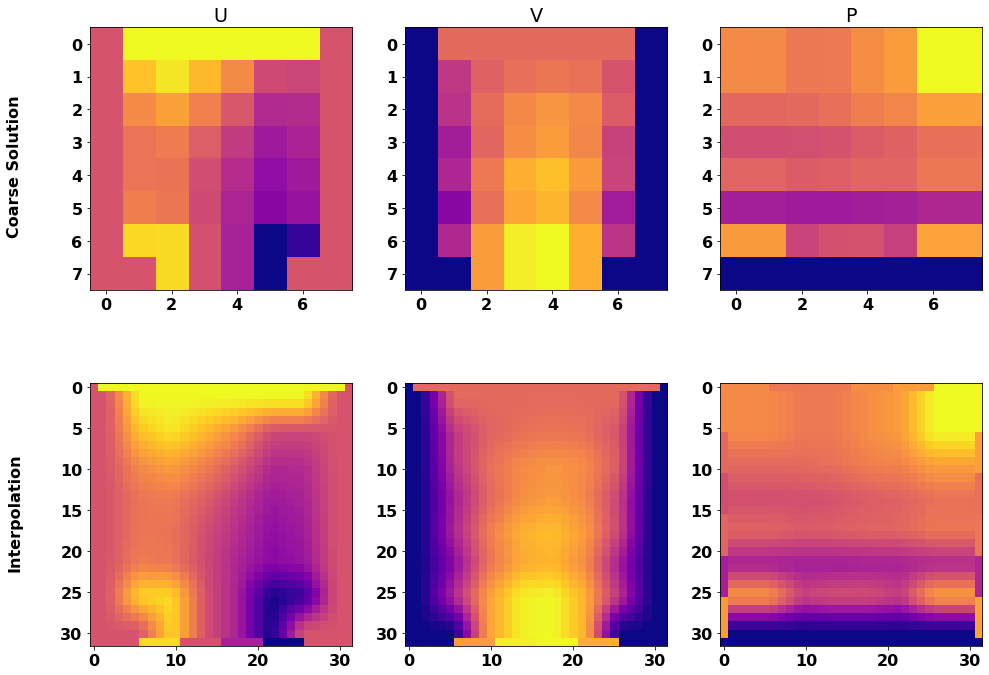

In [ ]:
plt.rcParams['image.cmap'] = 'plasma'
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 16}
plt.rc('font', **font)

fig1, axes = plt.subplots(2, 3, figsize = (16,12))

im00 = axes[0,0].imshow(B[0,0,:,:].detach().cpu().numpy())
im01 = axes[0,1].imshow(B[0,1,:,:].detach().cpu().numpy())
im02 = axes[0,2].imshow(B[0,2,:,:].detach().cpu().numpy())

im00 = axes[1,0].imshow(C[0,0,:,:].detach().cpu().numpy())
im01 = axes[1,1].imshow(C[0,1,:,:].detach().cpu().numpy())
im02 = axes[1,2].imshow(C[0,2,:,:].detach().cpu().numpy())
# im02 = axes[3].imshow(B[0,3,:,:].detach().cpu().numpy())

axes[0,0].set_title("U") 
axes[0,1].set_title("V") 
axes[0,2].set_title("P") 

fig1.text(0.06, 0.7, 'Coarse Solution', ha='center', va='center', rotation='vertical')
fig1.text(0.06, 0.3, 'Interpolation', ha='center', va='center', rotation='vertical')

fig1.savefig("input_8-32.png", transparent=True)

In [ ]:
A = torch.load('utils/FlowData_UV_1126_warm_mixed32_4D_large.pt')

A[:,0:3,0:1,1:-1] = F.interpolate(B[:,:,0:1,1:-1], size=(1, 62), mode = "nearest")
A[:,0:3,-1:,1:-1] = F.interpolate(B[:,:,-1:,1:-1], size=(1, 62), mode = "nearest")
A[:,0:3,1:-1,0:1] = F.interpolate(B[:,:,1:-1,0:1], size=(62, 1), mode = "nearest")
A[:,0:3,1:-1,-1:] = F.interpolate(B[:,:,1:-1,-1:], size=(62, 1), mode = "nearest")
A1 = 0.1 * torch.ones(2048,4,64,64)
A1[:,:,0,:] = A[:,:,0,:]
# A1[:,:,-1,:] = A[:,:,-1,:]
A1[:,:,:,0] = A[:,:,:,0]
A1[:,:,:,-1] = A[:,:,:,0]
A1[:,3,:,:] = A[:,3,:,:]

A1[:,0,:,:] = A1[:,0,:,:] * A[:,3,:,:]
A1[:,1,:,:] = A1[:,1,:,:] * A[:,3,:,:]
A1[:,2,:,:] = A1[:,2,:,:] * A[:,3,:,:]

Geometry = A1[0, 3, :, :]
geometry = Geometry.detach().cpu().numpy()
model_input = A1[0,:,:,:].detach().cpu().numpy()*geometry
model_input_inner = model_input[:, 4:-4, 4:-4]
model_input_inner[model_input_inner == 0] = np.nan

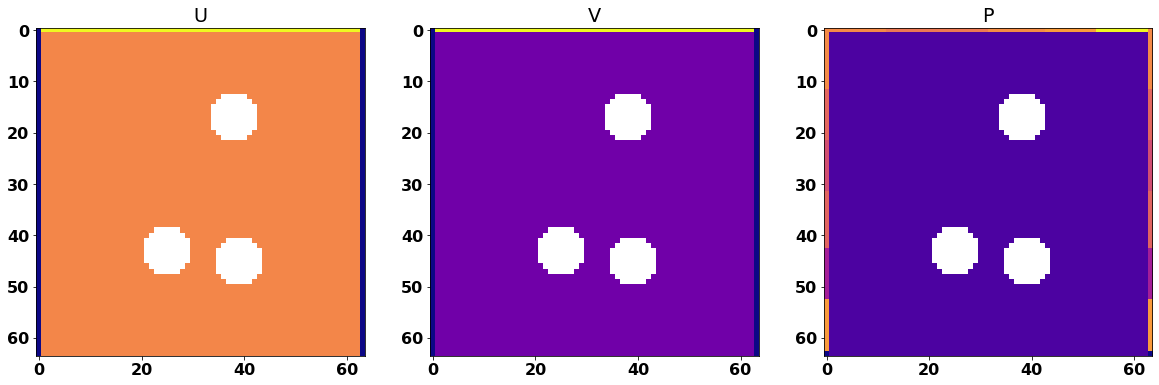

In [ ]:
fig2, axes = plt.subplots(1, 3, figsize = (20,12))

im00 = axes[0].imshow(model_input[0,:,:])
im01 = axes[1].imshow(model_input[1,:,:])
im02 = axes[2].imshow(model_input[2,:,:])
# im00 = axes[0].imshow(C[0,0,:,:].detach().cpu().numpy())
# im01 = axes[1].imshow(C[0,1,:,:].detach().cpu().numpy())
# im02 = axes[2].imshow(C[0,2,:,:].detach().cpu().numpy())
axes[0].set_title("U") 
axes[1].set_title("V") 
axes[2].set_title("P") 
fig2.savefig("input_8-64-obstacles.png", transparent=True)

## Load Model_3:

This model can take the input as zeros and get steady solution for different geometric masks

In [9]:
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
unet_large = UNet_4D(dtype, img_size=64).type(dtype)
# filename = 'trained_models/unet_4d_warm_single.pth' # the warm starting model
filename = 'trained_models/unet_4d_cold.pth' # the cold starting model
optimizer = optim.Adam(unet_large.parameters(), lr = 2e-5)
checkpoint = torch.load(filename)
unet_large.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
unet_large.eval()

UNet_4D(
  (encoding_layers): ModuleList(
    (0): Conv2d(4, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (encoding_BN): ModuleList(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): BatchNorm

### Show the results

In [11]:
A = torch.load('utils/FlowData_UV_1126_warm_mixed32_4D_large.pt')
# A = torch.load('utils/FlowData_UV_0331_warm_mixed32_4D_64.pt')

In [12]:
# Initialize the cold input data
A1 = 0.1 * torch.ones(2048,4,64,64)
A1[:,:,0,:] = A[:,:,0,:]
# A1[:,:,-1,:] = A[:,:,-1,:]
A1[:,:,:,0] = A[:,:,:,0]
A1[:,:,:,-1] = A[:,:,:,0]
A1[:,3,:,:] = A[:,3,:,:]

A1[:,0,:,:] = A1[:,0,:,:] * A[:,3,:,:]
A1[:,1,:,:] = A1[:,1,:,:] * A[:,3,:,:]
A1[:,2,:,:] = A1[:,2,:,:] * A[:,3,:,:]

In [13]:
plt.rcParams['image.cmap'] = 'plasma'
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 20}
axeslinewidth = 2.0
Pad = 10
LineWidth = 3.0
DPI = 600
plt.rc('font', **font)
plt.rcParams['axes.linewidth'] = axeslinewidth

unet_large.eval()
dtype = torch.cuda.FloatTensor
S = A1
img = S[0:10].type(dtype)
N = 7
size = 64
u0_vector = np.zeros((1,size))
v0_vector = np.zeros((1,size))
U0, V0 = 0.2, 0.5
u0_vector[0, 1:-1] = U0
v0_vector[0, 1:-1] = V0
img[N,0,0,:] = torch.from_numpy(u0_vector)
img[N,1,0,:] = torch.from_numpy(v0_vector)
# u = np.zeros((8, 8))
# v = np.zeros((8, 8))
# p = np.zeros((8, 8)) 
# L = 1
# H = 1
# dx = L / (8 - 1)
# dy = H / (8 - 1)
# CFL = 0.04
# dt = CFL * min(dx , dy)
# RE = 20
# sol_u, sol_v, sol_p = solve_flow(200, 8, 8, u, v, dt, dx, dy, p, u0=u0_vector, v0=v0_vector, geometry = None)
# smallsol = torch.zeros(1,3,8,8)
# smallsol[0, 0, :, :] = torch.from_numpy(sol_u)
# smallsol[0, 1, :, :] = torch.from_numpy(sol_v)
# smallsol[0, 2, :, :] = torch.from_numpy(sol_p)
# roughsol = F.interpolate(smallsol, size=(64, 64), mode ='bilinear')
# img[N, 0, 0, :] = u0_vector
# img[N, 1, 0, :] = v0_vector
# img[N, 0:3, 1:-1, 1:-1] = roughsol[:,0:3,1:-1,1:-1]

output = unet_large(img)
# output = unet_outlet(img)
Geometry = img[N, 3, :, :]
geometry = Geometry.detach().cpu().numpy()

newgeo = (~geometry.astype(bool)).astype(int)
# georows, geocols = np.nonzero(newgeo)
# # Not a good choice
# centerLeft = geocols[0]
# centerRight = geocols[-1]
# centerUpper = georows[0]
# centerLower = georows[-1]

print(output.size())

UMAX, UMIN = 1.0, 0
VMAX, VMIN = 1.0, 0
PMAX, PMIN = 1.0, 0
print("U0 is: ", img[N,0,0,:].detach().cpu().numpy())
print("V0 is: ", img[N,1,0,:].detach().cpu().numpy())
u0_vector = img[N,0,0,:].detach().cpu().numpy()
v0_vector = img[N,1,0,:].detach().cpu().numpy()


u = np.zeros((size, size))
v = np.zeros((size, size))
p = np.zeros((size, size)) 
L = 1
H = 1
dx = L / (size - 1)
dy = H / (size - 1)
CFL = 0.04
dt = CFL * min(dx , dy)
RE = 20
sol_u, sol_v, sol_p = solve_flow(10000, size, size, u, v, dt, dx, dy, p, u0=u0_vector, v0=v0_vector, geometry = geometry )


Solution = torch.zeros(1,3,size,size).type(dtype)

Solution[0,0,:,:] = torch.from_numpy(sol_u)
Solution[0,1,:,:] = torch.from_numpy(sol_v)
Solution[0,2,:,:] = torch.from_numpy(sol_p)

err_u = np.abs(output[N,0,:,:].detach().cpu().numpy() - sol_u)
err_v = np.abs(output[N,1,:,:].detach().cpu().numpy() - sol_v)
err_p = np.abs(output[N,2,:,:].detach().cpu().numpy() - sol_p)


model_input = img[N,:,:,:].detach().cpu().numpy()*geometry
model_input_inner = model_input[:, 4:-4, 4:-4]
model_input_inner[model_input_inner == 0] = np.nan


model_output = output[N,:,:,:].detach().cpu().numpy()*geometry
model_output_inner = model_output[:, 1:-1, 1:-1]
model_output_inner[model_output_inner == 0] = np.nan


model_sol = Solution[0,:,:,:].detach().cpu().numpy()
model_sol_inner = model_sol[:, 1:-1, 1:-1]
model_sol_inner[model_sol_inner == 0] = np.nan

fig1, axes = plt.subplots(3, 3, figsize = (24,18), dpi = DPI)

im00 = axes[0,0].imshow(model_input[0, :, :], vmin=UMIN, vmax=UMAX)
im01 = axes[0,1].imshow(model_input[1, :, :], vmin=VMIN, vmax=VMAX)
im02 = axes[0,2].imshow(model_input[2, :, :],  vmin=PMIN, vmax=PMAX)

# im10 = axes[1,0].imshow(sol_u)
# im11 = axes[1,1].imshow(sol_v)
# im12 = axes[1,2].imshow(sol_p)

# im20 = axes[2,0].imshow(output[N,0,:,:].detach().cpu().numpy()*geometry)
# im21 = axes[2,1].imshow(output[N,1,:,:].detach().cpu().numpy()*geometry)
# im22 = axes[2,2].imshow(output[N,2,:,:].detach().cpu().numpy()*geometry)


im10 = axes[1,0].imshow(model_sol[0, :, :])
im11 = axes[1,1].imshow(model_sol[1, :, :])
im12 = axes[1,2].imshow(model_sol[2, :, :])
axes[0,0].set_title("U", weight = 'bold') 
axes[0,1].set_title("V", weight = 'bold') 
axes[0,2].set_title("P", weight = 'bold') 

im20 = axes[2,0].imshow(model_output[0, :, :])
im21 = axes[2,1].imshow(model_output[1, :, :])
im22 = axes[2,2].imshow(model_output[2, :, :])

# axes[3,0].imshow(err_u, vmin=UMIN, vmax=UMAX)
# axes[3,1].imshow(err_v, vmin=VMIN, vmax=VMAX)
# axes[3,2].imshow(err_p, vmin=PMIN, vmax=PMAX)
fig1.colorbar(im00, ax=axes[0][0], format='%.2f', shrink=0.75)
fig1.colorbar(im01, ax=axes[0][1], format='%.2f', shrink=0.75)
fig1.colorbar(im02, ax=axes[0][2], format='%.2f', shrink=0.75)

fig1.colorbar(im10, ax=axes[1][0], format='%.2f', shrink=0.75)
fig1.colorbar(im11, ax=axes[1][1], format='%.2f', shrink=0.75)
fig1.colorbar(im12, ax=axes[1][2], format='%.2f', shrink=0.75)
fig1.colorbar(im20, ax=axes[2][0], format='%.2f', shrink=0.75)
fig1.colorbar(im21, ax=axes[2][1], format='%.2f', shrink=0.75)
fig1.colorbar(im22, ax=axes[2][2], format='%.2f', shrink=0.75)

# IM = axes[3,0].imshow(err_u, vmin=UMIN, vmax=UMAX)
# cb_ax = fig1.add_axes([0.15, 0.1, 0.7, 0.02])
# cbar = fig1.colorbar(IM, cax=cb_ax, orientation = "horizontal")
# print(get_loss(img,output))

U0 = 0.05
V0 = 0.5

fig1.text(0.08, 0.25, 'Model Generation', ha='center', va='center', rotation='vertical')
fig1.text(0.08, 0.5, 'FDM Solution', ha='center', va='center', rotation='vertical')
fig1.text(0.08, 0.775, 'Input', ha='center', va='center', rotation='vertical')
# fig1.suptitle('Generation for ' + '$U_0={}, V_0={}$'.format(U0, V0), fontweight='bold')
# del img, output


for ax in axes.flat:
    ax.set_xlabel('X', weight = 'bold')
    ax.set_ylabel('Y', weight = 'bold')



# # profile plots
# geometry = Geometry.detach().cpu().numpy()
# # fig2, axs = plt.subplots(1, 3, figsize = (18,12))
# axes[3,0].plot(img[N,1,31,:].detach().cpu().numpy(),'--',label="input")
# axes[3,0].plot((output.detach().cpu().numpy()*geometry[:,:,])[N,1,31,:],label="output" )
# axes[3,0].plot(sol_v[31,:],'-.',label="solution")
# axes[3,0].set_ylabel("V")

# axes[3,1].plot(img[N,1,41,:].detach().cpu().numpy(), '--')
# axes[3,1].plot((output.detach().cpu().numpy()*geometry[:,:,])[N,1,41,:])
# axes[3,1].plot(sol_v[41,:],'-.')

# axes[3, 2].plot(img[N,1,-1,:].detach().cpu().numpy(),'--')
# axes[3, 2].plot((output.detach().cpu().numpy()*geometry[:,:,])[N,1,-1,:])
# axes[3, 2].plot(sol_v[-1,:],'-.')
# fig1.legend(loc = 'lower right')

torch.Size([10, 3, 64, 64])
U0 is:  [0.  0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0. ]
V0 is:  [0.  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0. ]
0.0
0.0008921968067553864
0.002596283543044889
0.004843936738181275
0.007146131999704087
0.009259342160950914
0.010967875941882187
0.012074558025261752
0.012502129235313717
0.012265184185526289
0.011459715397646324
0.010251055099429964
0.008861017436657783
0.007634147031637052
0.007355073908038827
0.007305269781566986
0.007086992920964827
0.006669297517036699
0.006168956464699126
0.005470643828963085
0.004732591276206602
0.0049062

In [14]:
# fig1.savefig("warm_results_contour.png",  transparent=True, dpi=DPI)
# fig1.savefig("warm_results_contour.svg", transparent=True, dpi=DPI)

fig1.savefig("cold_results_contour.png",  transparent=True, dpi=DPI)
fig1.savefig("cold_results_contour.svg", transparent=True, dpi=DPI)

In [ ]:
# img[N,2,:,:].detach().cpu().numpy()

### Cross-line results

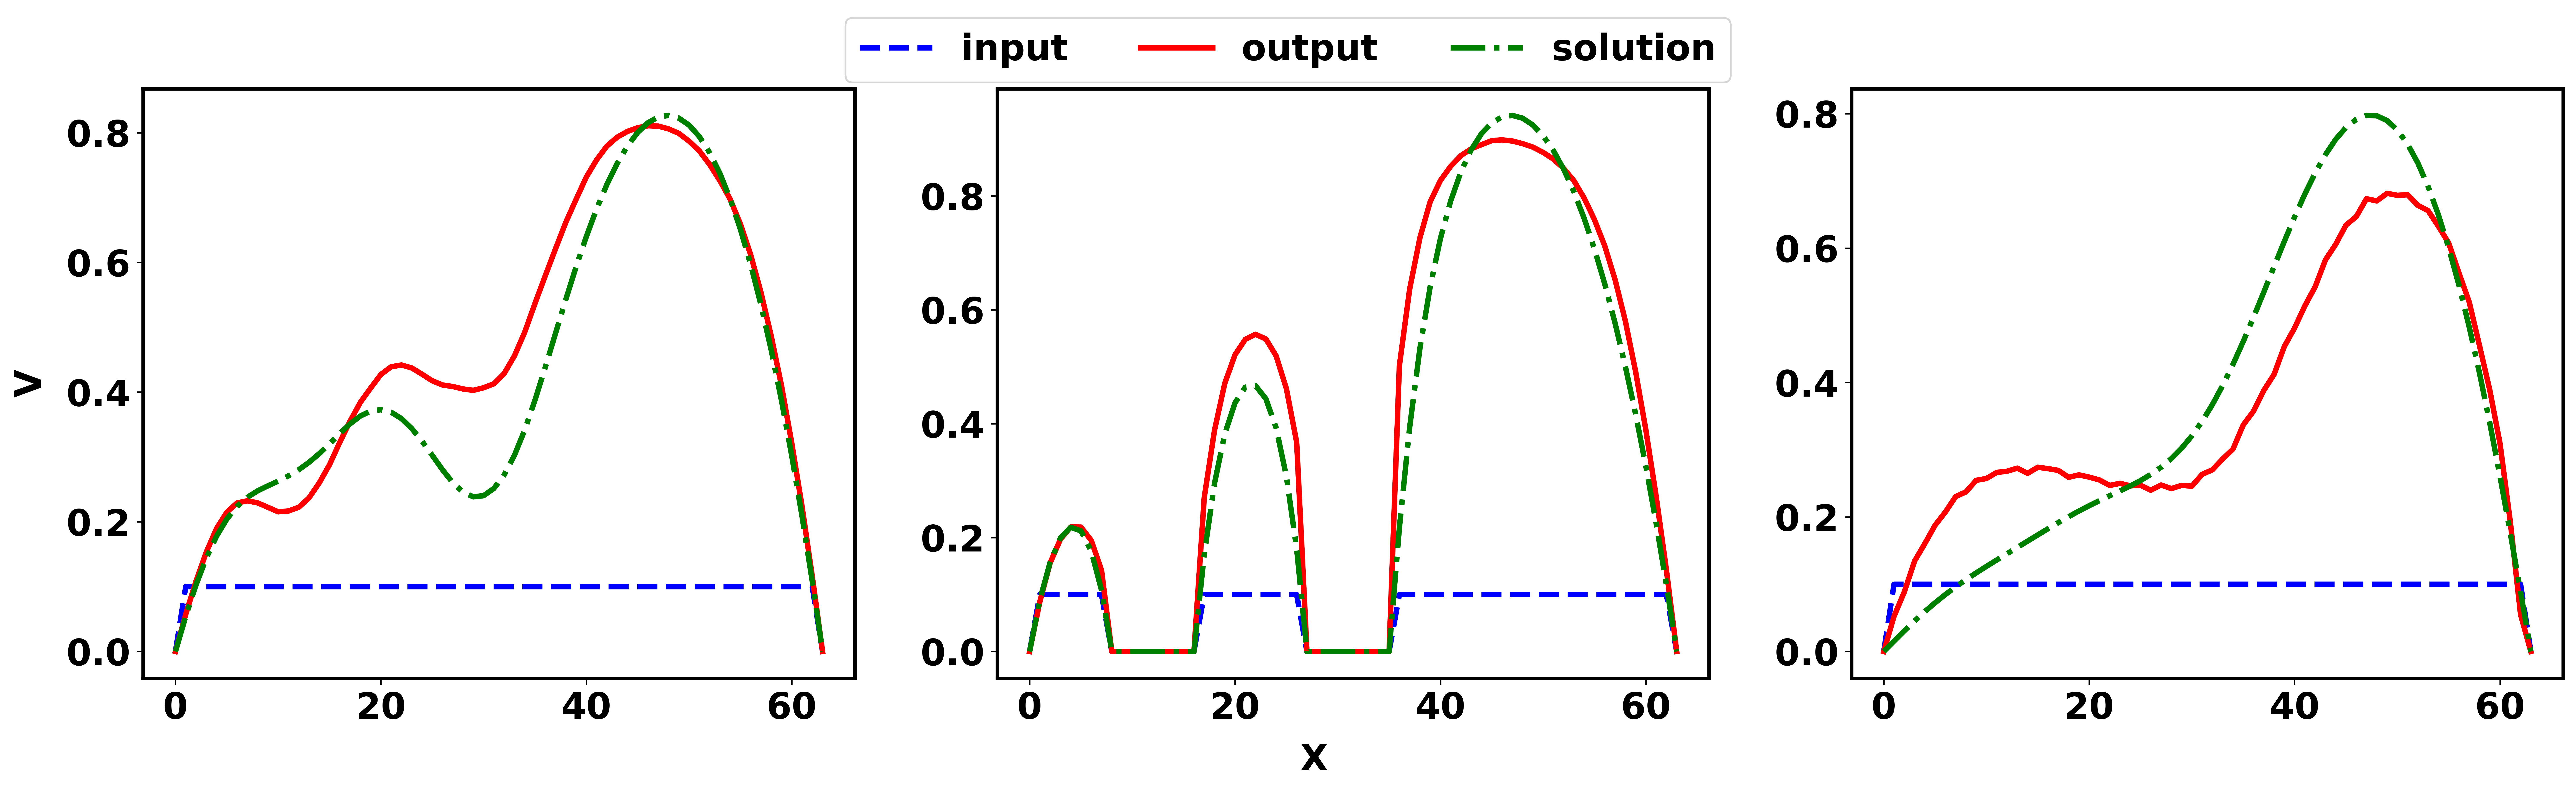

In [15]:
geometry = Geometry.detach().cpu().numpy()

width = 10 #inch
length = 8 #inch
DPI = 600
tiff_save = True
LabelSize = 20
axeslinewidth = 2.0
Pad = 10
LineWidth = 3.0

fig2, axs = plt.subplots(1, 3, figsize = (24,6), dpi=DPI)
axs[0].plot(img[N,1,31,:].detach().cpu().numpy(),'b--',label="input", linewidth=LineWidth)
axs[0].plot((output.detach().cpu().numpy()*geometry[:,:,])[N,1,31,:], 'r', label="output",linewidth=LineWidth)
axs[0].plot(sol_v[31,:],'g-.',label="solution", linewidth=LineWidth)
axs[0].set_ylabel("V", weight = 'bold', labelpad = 10)
# axs[0].set_xlabel("X", weight = 'bold', labelpad = 10)
# axs[0].legend()

axs[1].plot(img[N,1,41,:].detach().cpu().numpy(), 'b--', linewidth=LineWidth)
axs[1].plot((output.detach().cpu().numpy()*geometry[:,:,])[N,1,41,:], 'r', linewidth=LineWidth)
axs[1].plot(sol_v[41,:],'g-.',  linewidth=LineWidth)
# axs[1].set_xlabel("X", weight = 'bold', labelpad = 10)
# axs[1].legend()

axs[2].plot(img[N,1,-1,:].detach().cpu().numpy(),'b--',linewidth=LineWidth)
axs[2].plot((output.detach().cpu().numpy()*geometry[:,:,])[N,1,-1,:],'r', linewidth=LineWidth)
axs[2].plot(sol_v[-1,:],'g-.', linewidth=LineWidth)
# axs[2].set_xlabel("X", weight = 'bold', labelpad = 10)
# axs[2].legend()
fig2.text(0.5, 0.02, 'X', ha='center', va='center')
# fig2.text(0.05, 0.5, 'V', ha='center', va='center', rotation='vertical')

fig2.legend(loc = 'upper center', ncol = 3)
# fig2.savefig("outlet1022.png")

In [16]:
# fig2.savefig("warm_results_ln_plot3.png",  transparent=True, dpi=DPI)
# fig2.savefig("warm_results_ln_plot3.svg",  transparent=True, dpi=DPI)

fig2.savefig("cold_results_ln_plot3.png",  transparent=True, dpi=DPI)
fig2.savefig("cold_results_ln_plot3.svg",  transparent=True, dpi=DPI)

In [ ]:
import time
device = torch.device('cpu')
model = UNet_4D(dtype, img_size=64).type(dtype)
filename = 'trained_models/unet_4d_warm_single.pth' # the warm starting model
checkpoint = torch.load(filename, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

# Time check
t = time.process_time()
output = model(img[0:1,:,:,:])
elapsed_time = time.process_time() - t
elapsed_time

0.004893054000000063

In [ ]:
img[11:12,:,:,:]

tensor([], device='cuda:0', size=(0, 4, 64, 64))

In [ ]:
print("U_RMSE", torch.sqrt(torch.abs((output[N,0,1:-1,1:-1] - Solution[0,0,1:-1,1:-1])**2).mean()))
print("V_RMSE", torch.sqrt(torch.abs((output[N,1,1:-1,1:-1] - Solution[0,1,1:-1,1:-1])**2).mean()))
print("P_RMSE", torch.sqrt(torch.abs((output[N,2,1:-1,1:-1] - Solution[0,2,1:-1,1:-1])**2).mean()))

U_RMSE tensor(0.0836, device='cuda:0', grad_fn=<SqrtBackward>)
V_RMSE tensor(0.0766, device='cuda:0', grad_fn=<SqrtBackward>)
P_RMSE tensor(0.2908, device='cuda:0', grad_fn=<SqrtBackward>)
